<a href="https://colab.research.google.com/github/Gus-Victrix/starting_data/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A PyTorch Workflow


stuff_being_covered = {1: "data (preparation and loading)",
2: "build model",
3: "fitting model (training)"}

stuff_being_covered





In [266]:
stuff_being_covered = {
    1: "data (prep and loading)",
    2: "build model",
    3: "fitting model (training)",
    4: "making predictions (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}
stuff_being_covered

{1: 'data (prep and loading)',
 2: 'build model',
 3: 'fitting model (training)',
 4: 'making predictions (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [267]:
import torch
from torch import nn # Containing all the building blocks of neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu121'

## 1. Data (prep and loading)
Data can be almost anything... in machine learning

- Excel spreadsheet
- Images of any kind
- Videos
- Audio
- DNA
- Text

Machine learning is a two part game:
1. Get data into numerical representation
2. Build a model to learn patterns in the numerical representation

For starters, we known data using linear regression formula.
We'll use a linear regression formula to make a straight line with *known* **parameters**.

In [268]:
# Create known parameters
weight = 0.7
bias = 0.3


# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[: 10], y[: 10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

We know the rel btn X and y.

So we create a model that doesn't know it and then have it learn it.

## 2 Splitting data into training, validation and test set.

- training set: Used to teach the model
- validation set: Tunes the model (not always)
- testing set: Tests the models ability to generalize what it's learnt.

In [269]:
# Create a training and test set with our data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_test), len(X_train), len(y_test), len(y_train)

(10, 40, 10, 40)

## Visualizing the data

In [270]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions
        plt.scatter(test_data, predictions, c="r", s=4, label="predictions")

    # Display the plot
    plt.legend(prop={"size": 14})

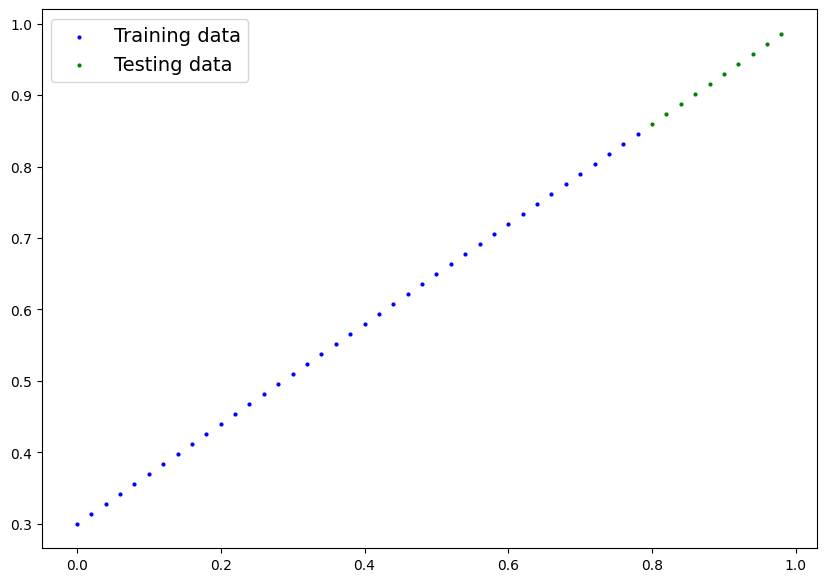

In [271]:
plot_predictions()

## 2. Build Model
My first PyTorch model!

What this model does:
- Start with random values (weight & bias)
- Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias values used to create the data)

How does it do this?

Through:
1. Gradient descent
2. Backpropagation

In [272]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # Almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with a random value and adjust it to model wight
                                                requires_grad=True, # <- can this parameter be updated via gradient descent?
                                                dtype=torch.float)) # <- PyTorch loves float32
        self.bias = nn.Parameter(torch.randn(1, # <- start with a random value
                                             requires_grad=True, # <- make the value updateable by gradient descent
                                             dtype=torch.float)) # <- the datatype of the parameter

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

- `torch.nn` - contains all building blocks ofor neural networks (computational graphs)
- `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from `torch.nn` will set these for us
- `torch.nn.Module` - the base class for all neural network modules, if subclassed, `forward()` should be overwritten.
- `torch.optim` - this is where the optimizers in PyTorch live, they will help with gradient descent.
- `def forward():` - All `nn.Module` subclasses require this method.




### Checking the contents of our PyTorch model

This is shown by using `.parameters()`

In [273]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [274]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [275]:
# The desired values are:
weight, bias

(0.7, 0.3)

### Making prediction using `torch.inference_model()`

To check our model's predictive power, we test it by checking how well it predicts `y_test` based on `X_test`

When data is passed into the model, it passes through the `forward()` model.

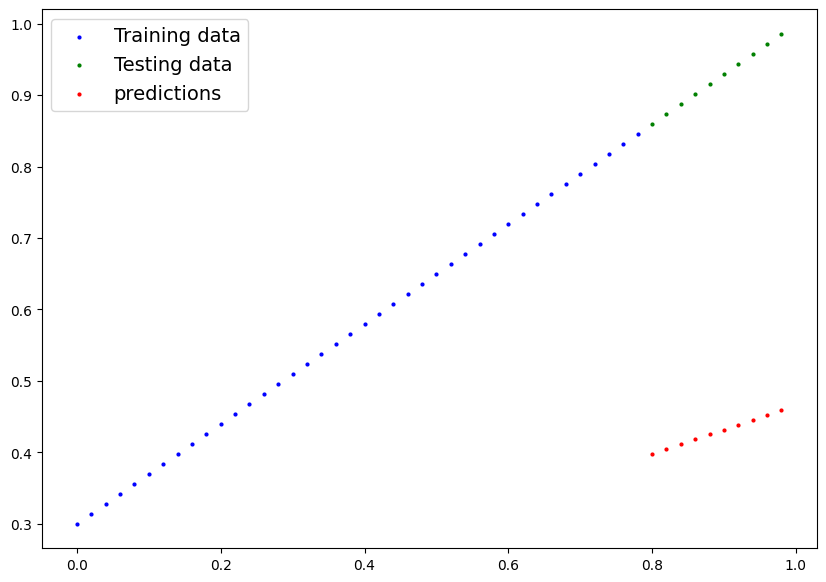

In [276]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

### 3. Training the model

The whole idea is to move from a random representation of the data to a more accurate representation of the data.

We measure the distance from accurate representation via a loss function.

- **Note**: loss functions are also criterion or cost function.

Things needed for training:
- **Loss Function:** Function that measures how wrong your model's predictions are compared to ideal representation.
- **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (eg weight and bias) to improve the loss function.

In PyTorch, we need:
- A training loop
- A testing loop

In [277]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [278]:
# Creating the loss function (Mean Absolute Error for this model)
# Can be done using `torch.mean(torch.abs(y_pred-y_test))`
# Better done using PyTorch's internally implemented `torch.nn.L1Loss()`

loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.ASGD(params=model_0.parameters(),
                        lr=0.0001) # Learning rate = how much change done per size of error



**Q:** Which loss function is bette?
**A:** This is problem specific, but bad ones are learnt per use-case with experience.

For regression problem, `nn.L1Loss()` loss function and `torch.optim.SGD()` optimizer will suffice.

For binary classification (eg cat vs dog), `nn.BCELoss()` (binary cross entropy loss) is preferred.

## Building a training loop (and testing loop) in PyTorch

What is needed when training:
1. Loop through the data
2. Forward pass (involves moving data through the `forward()` function) -- Also called forward propagation.
3. Calculate the loss (compare forward pass predictions to ground truth labels)
4. Optimizer zero grad
5. Loss backward - Move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**).
6. Optimizer step - use the optimizer to adjust the model's parameters to try and improve the loss.



In [279]:
# An epoch is one loop through the data
epochs = 17500
# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 1. Loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train()  # sets all parameters that require gradients to require gradients
    #1. Forward pass
    y_pred = model_0(X_train)
    #2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    #3. Optimizer zero grad
    optimizer.zero_grad()
    #4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    #5. Step the optimizer (Perform gradient descent)
    optimizer.step()  # by default how the optimizer changes will accumulate through the loop so it has to be zeroed in step 3

    # Testing loop
    model_0.eval()  # turns off stuff not needed for testing
    with torch.inference_mode(): # turns off gradient tracking
        # 1. Do the forward pass
        test_pred = model_0(X_test)
        #2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    # print out what's hapening
    if epoch % 5 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)


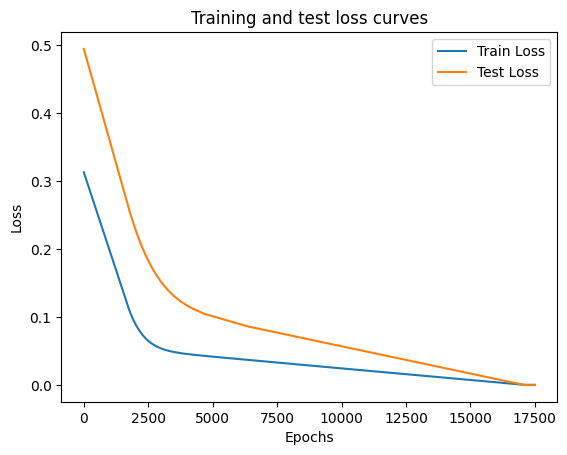

In [280]:
import numpy as np
# Plot the trends
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train Loss')
plt.plot(epoch_count, test_loss_values, label='Test Loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

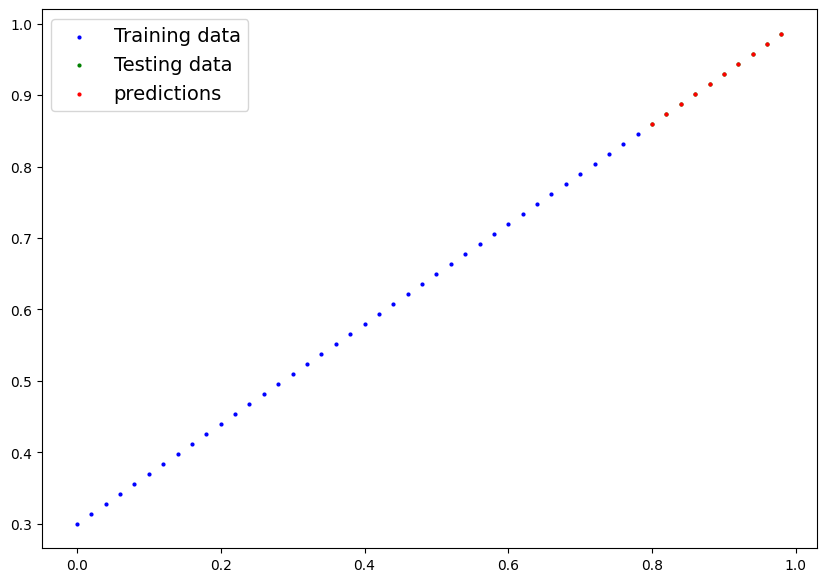

In [281]:
model_0.eval()
plot_predictions(predictions=model_0(X_test).detach().numpy())

In [282]:
# Comparing the current weight and bias vs best
print(f"Best is {(weight, bias)}")
print(f"Current is {model_0.state_dict()}")

Best is (0.7, 0.3)
Current is OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3000]))])


## Saving a model in PyTorch

There are three main methods for loading and saving

1. `torch.save()` - allows you to save a PyTorch object in Python pickle format
2. `torch.load()` - allows you to load a saved PyTorch object.
3. `torch.nn.Module.load_state_dict()` - this allows loading of a model's saved state dictionary.

In [283]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3000]))])

In [284]:
# Saving the model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#3. Save the model state dict
print(f'saving model to : {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

saving model to : models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model
Since we saved our model's `state_dict()` rather than the entire model,

In [285]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [286]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3000]))])

In [287]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3000]))])

In [288]:
# Make some predictions wit hour loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8599],
        [0.8739],
        [0.8879],
        [0.9019],
        [0.9159],
        [0.9299],
        [0.9439],
        [0.9579],
        [0.9719],
        [0.9859]])

In [289]:
# Compare with old model
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together
Let's go back through the steps above and see it all in one place

In [290]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu121'

Create device-agnostic code.

Code will use gpu if it's available.

In [291]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [292]:
!nvidia-smi

Fri Mar  1 17:51:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              30W /  70W |    175MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 6.1. Data

In [293]:
# Create data using linear regression formula
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [294]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

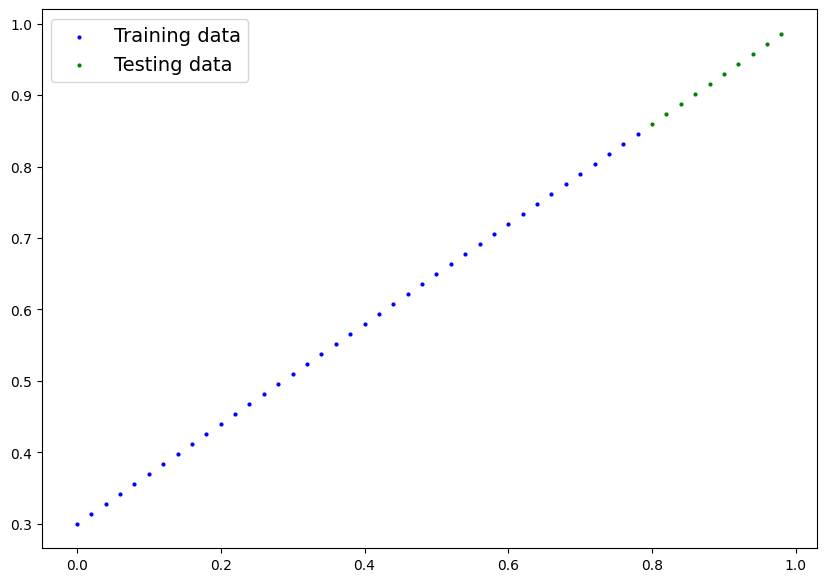

In [295]:
# Plot the data
# Note: Must load cell with the plotting function definition
plot_predictions(X_train, y_train, X_test, y_test)

In [296]:
# Create model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(X)

In [297]:
# manually set seed for reproducibility
torch.manual_seed(42)
# instantiate model
model_1 = LinearRegressionModelV2()

# Send model to GPU if available
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [298]:
# Create loss function
loss_fn = nn.L1Loss()
# Create optimizer
optimizer = torch.optim.ASGD(params=model_1.parameters(), lr=0.001)

In [299]:
# Set no. of epochs
epochs = 1200
# Set track-worthy metrics
epoch_count = []
train_loss = []
test_loss_values = []

# move data to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Create training loop
for epoch in range(epochs):
    # Enter training mode
    model_1.train()
    # Perform forward pass
    y_pred = model_1(X_train)
    # Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # Restore gradients to zero
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Move the optimizer
    optimizer.step()

    if epoch % 5 == 0:
        epoch_count.append(epoch)
        train_loss.append(loss)

        # Test the model
        model_1.eval()
        with torch.inference_mode():
            # Forward pass
            test_pred = model_1(X_test)
            # Evaluate loss
            test_loss = loss_fn(test_pred, y_test)
            test_loss_values.append(test_loss)

In [300]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6995]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3005], device='cuda:0'))])

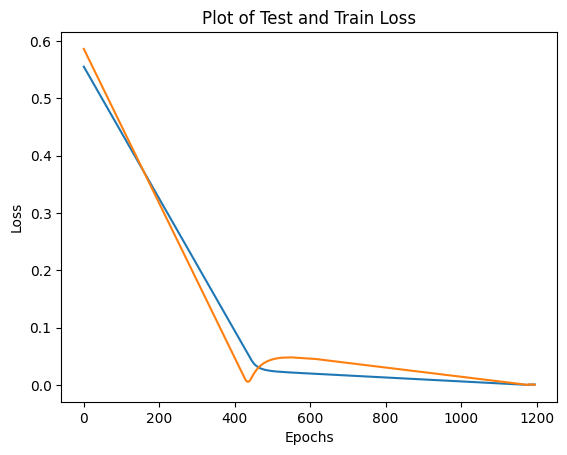

In [301]:
# Plot progress
plt.plot(epoch_count, np.array(torch.tensor(train_loss).numpy()), label='Train Loss')
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label='Test Loss')
plt.title('Plot of Test and Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

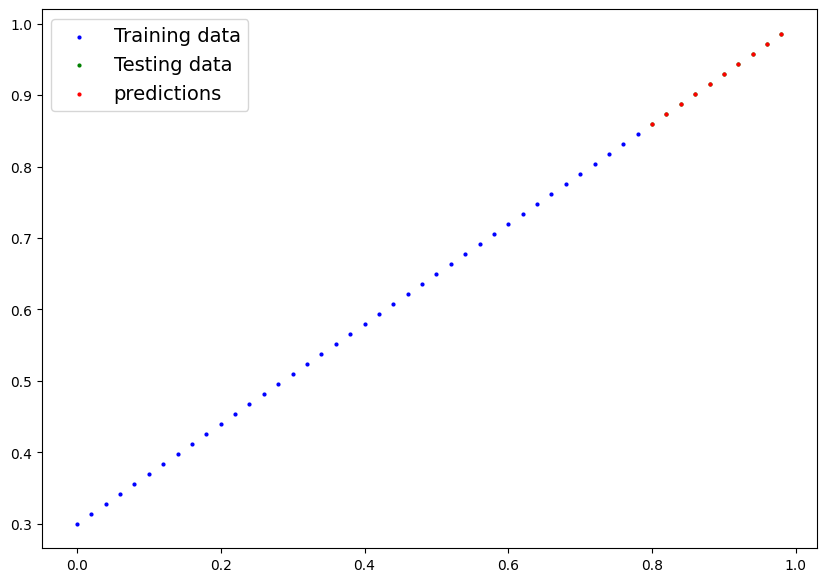

In [302]:
plot_predictions(predictions=y_preds.cpu())

In [303]:
# Save the model
from pathlib import Path

# Create directory name
MODEL_DIRECTORY = Path("models")
# Create the directory
MODEL_DIRECTORY.mkdir(parents=True, exist_ok=True)

# Create model name
MODEL_NAME = Path("LinearRegressionV2model_1.pth")
# Create model path
MODEL_PATH = MODEL_DIRECTORY / MODEL_NAME
# Save the model
torch.save(obj=model_1.state_dict(), f=MODEL_PATH)

In [304]:
# Loading saved model
# Create new model
model_1_load = LinearRegressionModelV2()

# loading saved model state
model_1_load.load_state_dict(torch.load(f=MODEL_PATH))
model_1_load.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)